In [1]:
print("Working")


Working


In [2]:
from torch.utils.data import DataLoader

import sys
import time
import torch.nn as nn
import numpy as np
import  pandas as pd
import  torch
from torchvision import models, transforms,datasets
from PIL import Image
import os
import matplotlib.pyplot as plt
from collections import Counter
from src.model import SkinCancerModel
from src.dataset import MelanomaDataset,data_preprocessing,Normalize,MelanomaImageDataset,MelanomaHam1000Dataset
from torch.utils.data import DataLoader
from src import model_training
from torch.optim import Adam
import time
from sklearn.model_selection import train_test_split
torch.cuda.CUDA_LAUNCH_BLOCKING=1

In [3]:
torch.cuda.empty_cache()

In [4]:

train_history=pd.read_csv("train_data.csv",index_col=False)

In [5]:
train_history

,Unnamed: 0,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Notes,Date,Time
0,0,0.333126,7511,0.322510,2504,10.78542274236679:00,"data standardization + classifier (1280,256,1)",18/05/2022,03:42 AM
1,0,0.310118,7511,0.295588,2504,8.317672594388325:00,"data standardization + classifier (1280,256,1)",18/05/2022,03:52 AM
2,0,0.307698,7511,0.313486,2504,8.297154140472411:00,"data standardization + classifier (1280,256,1)",18/05/2022,04:01 AM
3,0,0.295923,7511,0.287476,2504,8.17770220041275:00,"data standardization + classifier (1280,256,1)",18/05/2022,04:09 AM
4,0,0.284783,7511,0.285172,2504,8.252407503128051:00,"data standardization + classifier (1280,256,1)",18/05/2022,04:17 AM
...,...,...,...,...,...,...,...,...,...
105,0,0.112888,7335,0.365248,2446,27.697022040685017:00,"data standardization + classifier (1280,256,1)",21/05/2022,12:43 PM
106,0,0.118849,7335,0.360437,2446,102.00232036511103:00,"data standardization + classifier (1280,256,1)",21/05/2022,02:25 PM
107,0,0.110279,7335,0.328679,2446,402.89752440452577:00,"data standardization + classifier (1280,256,1)",21/05/2022,09:08 PM
108,0,0.107282,7335,376.438428,2446,402.89752440452577:00,"data standardization + classifier (1280,256,1)",21/05/2022,09:37 PM


In [6]:
def save_weights(model,path):
    state_dict = model.state_dict()
    torch.save(state_dict, path)

In [7]:
img_dataset_path="../dataset/preprocessed/ham1000"
img_train_csv_path="..\\dataset\\preprocessed\\ham1000_train.csv"
img_test_csv_path="..\\dataset\\preprocessed\\ham1000_test.csv"
weights_path="..\\model_weights\\weights.pt"

train_transform=transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),Normalize()])
test_transform=transforms.Compose([transforms.ToTensor(),Normalize()])






In [8]:
train_data=MelanomaHam1000Dataset(img_train_csv_path,img_dataset_path,train_transform)
test_data=MelanomaHam1000Dataset(img_test_csv_path,img_dataset_path,test_transform)

In [ ]:
train_loader=DataLoader(train_data,shuffle=True,batch_size=4)
test_loader=DataLoader(test_data,shuffle=True,batch_size=1)

In [23]:
img,data,label=next(iter(train_data))
data


tensor([45.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.])

# Melanoma Features extraction Model Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


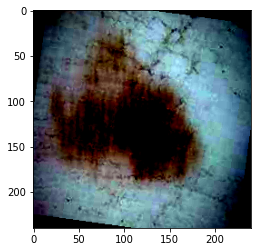

In [16]:
img,d,l=next(iter(train_data))
plt.imshow(img.numpy().transpose([1,2,0]))
plt.show()

In [17]:
from src.model import SkinCancerModel

In [18]:

model=SkinCancerModel(True,"efficientnet_b1")


In [19]:
model

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [20]:
len(model.features)

9

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.25, inplace=False)
  (1): Linear(in_features=1280, out_features=256, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [15]:
for i in range(4):
        for par in model.features[i].parameters():
          par.requires_grad=False

In [39]:
model.save_weights("weights.pt")

In [25]:
model.load_local_weights("weights.pt")

In [16]:
from torch.optim import Adam
import time
optimizer=Adam(model.parameters(),lr=0.001)
loss_function=torch.nn.BCELoss()

In [34]:
train_losses_list=[]
test_losses_list=[]
epochs=100
min_train_loss=800000
min_test_loss=800000
train_notes="data standardization + classifier (1280,256,1)"

In [17]:
import torch.nn as nn
#model.classifier=nn.Sequential(nn.Dropout(0.25),nn.Linear(1280,1),nn.Sigmoid())

In [ ]:


no_batches=len(train_loader)


dataset_size=float(len(train_loader.dataset))
model.cuda()
for e in range(epochs):
  train_loss_sum=0.0
  cnt=0.0
  time_sum=0.0

  epoch_time_start=time.time()
  for img,value in train_loader:
    ts=time.time()
    optimizer.zero_grad()
    img=img.cuda()
    output=model(img)
    value=value.cuda()

    loss=loss_function(output,value)

    loss.backward()
    optimizer.step()
    current_train_loss=loss.item()*train_loader.batch_size
    train_loss_sum+=current_train_loss

    # calculate epoch info
    cnt+=1.0
    finished=int((cnt*10)/no_batches)
    remaining=10-finished
    te=time.time()
    time_sum+=(te-ts)
    avg_time=time_sum/cnt
    time_remaing=avg_time*(no_batches-cnt)
    sys.stdout.flush()
    sys.stdout.write("\r epoch "+str(e+1)+" ["+str("="*int((cnt*10)/no_batches)+str("."*remaining)+"] time remaining = "+str(time_remaing/60.0)[:8])+" Avg train_loss="+str(train_loss_sum/(cnt*train_loader.batch_size)))
    # print()

  train_loss_avg=train_loss_sum/dataset_size
  train_losses_list.append(train_loss_avg)





  #test


  test_loss=0.0
  model.eval()
  with torch.no_grad():
    for img ,label in test_loader:
      img=img.cuda()
      label=label.cuda()
      output=model(img)
      losses=loss_function(output,label)
      test_loss+=losses.item()*test_loader.batch_size


  test_loss/=len(test_loader.dataset)
  test_losses_list.append(test_loss)
  print()
  if train_loss_avg<min_train_loss and test_loss<min_test_loss:
    save_weights(model,"weights.pt")
    min_train_loss=train_loss_avg
    min_test_loss=test_loss
    print(f"new train loss ={train_loss_avg } new test loss= {test_loss}")


  if test_loss>train_loss_avg:
    print(" over fitting")
  epoch_time_end=time.time()
  epoch_time=f"{(epoch_time_end-epoch_time_start)/60}:00"

  model_training.save_epochs_to_csv("",train_loss_avg,len(train_loader.dataset),test_loss,len(test_loader.dataset),epoch_time,train_notes)

  print(f" epoch {e+1} train_loss ={train_loss_avg} test_loss={test_loss}")


 epoch 1 [==========] time remaining = 0.0 Avg train_loss=0.3249464031516336507665
new train loss =0.32499070395642526 new test loss= 0.4230714756526161
 over fitting
 epoch 1 train_loss =0.32499070395642526 test_loss=0.4230714756526161
 epoch 2 [==========] time remaining = 0.0 Avg train_loss=0.3169447638047706631167
new train loss =0.3169879737248531 new test loss= 0.2799456094881673
 epoch 2 train_loss =0.3169879737248531 test_loss=0.2799456094881673
 epoch 3 [==========] time remaining = 0.0 Avg train_loss=0.3017219066657451678687
 over fitting
 epoch 3 train_loss =0.3017630412133478 test_loss=0.31326151797242857
 epoch 4 [==========] time remaining = 0.0 Avg train_loss=0.2919612938473194579626
 over fitting
 epoch 4 train_loss =0.2920010977046946 test_loss=0.29396517834924935
 epoch 5 [==========] time remaining = 0.0 Avg train_loss=0.2878951615369051798477
new train loss =0.2879344110476804 new test loss= 0.2656373784042368
 epoch 5 train_loss =0.2879344110476804 test_loss=0.2656

KeyboardInterrupt: 

In [40]:
  model_training.save_epochs_to_csv("",train_loss_avg,len(train_loader.dataset),test_loss,len(test_loader.dataset),epoch_time,train_notes)


In [18]:
model.cuda()

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [30]:
model.load_local_weights("weights.pt")

In [14]:
model.cuda()

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [31]:
count=0
loss_test=0.0
melanoma_score_sum=0.0
cnt_melanoma=0
cnt_non_melanoma=0
non_melanona_score_sum=0.0
model.eval()
with torch.no_grad():
  for img ,label in test_loader:
          img=img.cuda()
          label=label.cuda()
          result=model(img)

          if label.item()==1:
            melanoma_score_sum+=result.cpu().item()
            cnt_melanoma+=1
          else:
            non_melanona_score_sum+=result.cpu().item()
            cnt_non_melanoma+=1

          if result>0.28:
                result=1
          else:
                  result=0

          if result==label:
                  count+=1
model.train()

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [32]:
cnt_non_melanoma

2183

In [34]:
accuracy=(count/len(test_loader))*100
print(accuracy)
print(melanoma_score_sum/cnt_melanoma)
print(non_melanona_score_sum/cnt_non_melanoma)

10.752248569092396
0.8409142965599611
0.8229431989703001


In [103]:
len(train_loader)

1834

# Melanoma Classifier Model Train

In [18]:
img.shape

torch.Size([3, 240, 240])

In [19]:
data.shape

torch.Size([16])